In [61]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.spatial.distance import cdist

In [62]:
# classes to cluster the data
class BaseCluster:
    """
    class to represent initial data
    """
    def __init__(self, datapoint, cluster_name):
        if len(datapoint.shape ) == 1:
            self.data = np.expand_dims(datapoint,axis=0)
        else:
            self.data = datapoint
        self.cluster_name = cluster_name     # name of cluster : will be used to order data in the dendrogram
        self.plotline_yaxis_start_line = 0   # start of line in dendrogram                   
        self.plotline_yaxis_end_line = None  # end of line in dendrogram  
        self.number_baseclusters = 1         # number of baseclusters in it, 1 for each basecluster    
        self.xvalue = None                   # x coordinated in dendrogram, will be populated in after clustering is complete
    
    def set_plotline_yaxis_end_line(self, distance):
        # once two clusters are merged , the end of line in the dendrogram is the distance
        self.plotline_yaxis_end_line = distance       

    def normalize_plot_line_height(self, scaling_factor):
        # to normalize high of the dendrogram for each clusted, unused in this tutorial
        self.plotline_end_line = self.plotline_end_line / scaling_factor

class MixCluster:
    """ 
    Class to represent mixture clusters:
     - basecluster + basecluster
     -  mixcluster + basecluster
     -  mixcluster + mixcluster 
    """
    def __init__(self, cluster1, cluster2, distance):
        self.rightcluster = cluster1       # clusters that have merged in the current MixCluster
        self.leftcluster = cluster2        # clusters that have merged in the current MixCluster
        self.cluster_name = cluster1.cluster_name +'-' + cluster2.cluster_name # concatenate the name of the clusters (useful to arrange BaseCluster on dendrogram)
        self.plotline_yaxis_end_line = None   
        self.xvalue = None                  # x coordinated in dendrogram, will be populated in after clustering is complete

        cluster1.set_plotline_yaxis_end_line(distance) # update the end of line in dendrogram in lower clusters (the right one belonging to current MixCluster)
        cluster2.set_plotline_yaxis_end_line(distance) # update the end of line in dendrogram in lower clusters (the left one belonging to current MixCluster)
        self.plotline_yaxis_start_line = distance      # start of line in dendrogram for current mixcluster        
        self.number_baseclusters = cluster1.number_baseclusters + cluster2.number_baseclusters  # how many baseclusters are inside the current MixCluster
        self.data = np.concatenate([cluster1.data, cluster2.data],axis=0)    # The current MixCluster will contain the data of the cluster it contains

    def set_plotline_yaxis_end_line(self, distance):
        # once two clusters are merged , the end of line in the dendrogram is the distance
        self.plotline_yaxis_end_line = distance


# function to calcuate the distance between MixClusters or BaseClusters
def calculate_distance(cluster1, cluster2, metric = 'euclidean', linkage = 'single'):
    assert linkage in ['single', 'complete', 'average', 'ward'], "linakage not valid"
    assert metric in ['euclidean', 'ward'], "not implemented "
    if metric == 'euclidean':
        distances = cdist(cluster1.data, cluster2.data, metric= 'euclidean')
        if linkage== 'single':
            return np.min(distances)
        
        elif linkage== 'complete':
            return np.max(distances)
        
        elif linkage== 'average':
            return np.mean(distances)
        
    elif metric== 'ward':
        
        center = np.mean(np.concatenate([ cluster1.data , cluster2.data ]), axis= 0)
        # print()
        # print(cluster1.data)
        # print(cluster2.data)

        sum2 = np.sum( np.sum((cluster1.data - center ) **2) + np.sum((cluster2.data - center ) **2))
        return sum2

# generate distance matrix 
def generate_distance_matrix(clusters_list, metric, linkage):
    distances = np.zeros(shape=(len(clusters_list), len(clusters_list)))
    for r in range(distances.shape[0]):
        for c in range(distances.shape[1]):
            if r == c :
                distances[r,c] = float('1e10')  # set the distance on the diagnonal to high value
            else:
                distances[r,c] = calculate_distance(cluster1=clusters_list[r], cluster2 = clusters_list[c], metric = metric, linkage = linkage)

    return distances

In [63]:
# function that clusters all data together
def clustering(data, metric = 'euclidean', linkage ='single'):

    """   
    it returns MixCluster that contains MixCluster and BaseClusters and all data in a hierarchical manner
    
    """

    # create a BaseCluster for each datapoint
    baseclusters = [BaseCluster(datapoint=data[i], cluster_name= "Basecluster_" +str(i)) for i in range(data.shape[0])]
    # print([i.cluster_name for i in baseclusters])
    # original_clusters = baseclusters.copy() 
    # print(baseclusters)
    while True:

        # generate the distance matrix
        distances = generate_distance_matrix(clusters_list = baseclusters, metric=metric ,  linkage=linkage)
        
        # find min distance and identify the closest clusters that need to be merged
        min_distance = np.min(distances)
        min_indices = np.where(distances == min_distance)[0][:2]
        c,r = min_indices

        # Merge cluster into a new cluster MixCluster
        new_cluster = MixCluster(cluster1=baseclusters[c], cluster2=baseclusters[r], distance= min_distance)

        # update the original list of clusters
        baseclusters.pop(max(c,r))
        baseclusters.pop(min(c,r))
        baseclusters.append(new_cluster)

        # when only one cluster is left, all data has been clustered, break the loop
        if len(baseclusters)==1 :
            break

    return baseclusters[0] # if len(baseclusters) == 1 else baseclusters, original_clusters


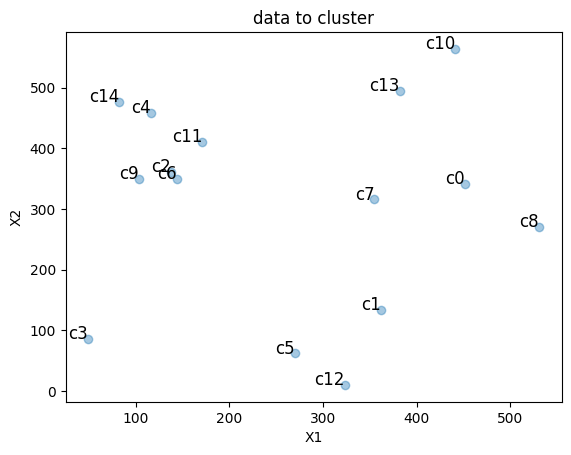

In [64]:
# generate and visualiaze some data 
np.random.seed(8)
data = np.random.randint(low = 1, high= 600 , size=(15,2))


# plot the data
plt.scatter(data[:,0], data[:,1], alpha= 0.4)
names = ["c" + str(i) for i in range(data.shape[0])]
for i in range(data.shape[0]):
    plt.text(data[i,0], data[i,1], names[i], fontsize=12, ha='right')

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('data to cluster')
plt.show()

### Cluster the data 

In [65]:
# cluster the data 
# the final cluster is a MixCluster object that contains MixClusters and BaseClusters
master_cluster =  clustering(data=data , 
                             metric='euclidean', 
                             linkage= 'average')

In [66]:
# inspect the name of master_cluster
master_cluster.cluster_name # the name of the cluster shows how to organize the data (base clusters) on the x axis of the dendrogram

'Basecluster_3-Basecluster_1-Basecluster_5-Basecluster_12-Basecluster_4-Basecluster_14-Basecluster_11-Basecluster_9-Basecluster_2-Basecluster_6-Basecluster_10-Basecluster_13-Basecluster_8-Basecluster_0-Basecluster_7'

In [67]:
# inspect the immediate RIGHT cluster of the final cluster which for this specific data turned out to be a BaseCluster 
print('right cluster type:',master_cluster.rightcluster) 
print('right cluster name:',master_cluster.rightcluster.cluster_name) 
print('right cluster plotline_yaxis_start_line:',master_cluster.rightcluster.plotline_yaxis_start_line) 
print('right cluster plotline_yaxis_end_line:',master_cluster.rightcluster.plotline_yaxis_end_line) 
print('right cluster xvalue:',master_cluster.rightcluster.xvalue) 

right cluster type: <__main__.MixCluster object at 0x0000027EB00811C0>
right cluster name: Basecluster_3-Basecluster_1-Basecluster_5-Basecluster_12
right cluster plotline_yaxis_start_line: 274.4344438282492
right cluster plotline_yaxis_end_line: 383.4572973582397
right cluster xvalue: None


In [68]:
# inspect the immediate LEFT cluster of the final cluster which for this specific data turned out to be a MixCluster  
print('right cluster type:',master_cluster.leftcluster) 
print('right cluster name:',master_cluster.leftcluster.cluster_name) 
print('right cluster plotline_yaxis_start_line:',master_cluster.leftcluster.plotline_yaxis_start_line) 
print('right cluster plotline_yaxis_end_line:',master_cluster.leftcluster.plotline_yaxis_end_line) 
print('right cluster xvalue:',master_cluster.leftcluster.xvalue) 

right cluster type: <__main__.MixCluster object at 0x0000027EB0081B20>
right cluster name: Basecluster_4-Basecluster_14-Basecluster_11-Basecluster_9-Basecluster_2-Basecluster_6-Basecluster_10-Basecluster_13-Basecluster_8-Basecluster_0-Basecluster_7
right cluster plotline_yaxis_start_line: 329.91729128563736
right cluster plotline_yaxis_end_line: 383.4572973582397
right cluster xvalue: None


In [69]:
# function that adds the x coordinates of the lines in the dendrogram for each cluster
def complete_xcoordinates(clustered_data):
    xaxis_sequence = clustered_data.cluster_name.split('-')
    #print(xaxis_sequence)

    def add_x(parent):
        #print(parent.cluster_name)
        child_right = parent.rightcluster
        child_left = parent.leftcluster
        if child_right.xvalue != None and child_left.xvalue != None:
            #print(child_right.xvalue , child_left.xvalue)
            parent.xvalue = np.mean([child_right.xvalue, child_left.xvalue])
        
        else:
            for clu in [child_right, child_left]:
                if isinstance(clu , BaseCluster):
                    if clu.xvalue == None:
                        # print(clu.cluster_name)
                        # print(xaxis_sequence.index(clu.cluster_name))
                        clu.xvalue = xaxis_sequence.index(clu.cluster_name)
                else:
                    add_x(clu)

    while clustered_data.xvalue == None:
        add_x(clustered_data)

    return clustered_data

# add x coordinates to the clustered data 
clustered_data = complete_xcoordinates(clustered_data = master_cluster)

In [70]:
# re inspect the uppermost right and left cluster:
print('RIGTH cluster')
print('right cluster type:',master_cluster.rightcluster) 
print('right cluster name:',master_cluster.rightcluster.cluster_name) 
print('right cluster plotline_yaxis_start_line:',master_cluster.rightcluster.plotline_yaxis_start_line) 
print('right cluster plotline_yaxis_end_line:',master_cluster.rightcluster.plotline_yaxis_end_line) 
print('right cluster xvalue:',master_cluster.rightcluster.xvalue)  # note that xvalue is now populated 

print('LEFT cluster')
print('right cluster type:',master_cluster.leftcluster) 
print('right cluster name:',master_cluster.leftcluster.cluster_name) 
print('right cluster plotline_yaxis_start_line:',master_cluster.leftcluster.plotline_yaxis_start_line) 
print('right cluster plotline_yaxis_end_line:',master_cluster.leftcluster.plotline_yaxis_end_line) 
print('right cluster xvalue:',master_cluster.leftcluster.xvalue) # note that xvalue is now populated 

RIGTH cluster
right cluster type: <__main__.MixCluster object at 0x0000027EB00811C0>
right cluster name: Basecluster_3-Basecluster_1-Basecluster_5-Basecluster_12
right cluster plotline_yaxis_start_line: 274.4344438282492
right cluster plotline_yaxis_end_line: 383.4572973582397
right cluster xvalue: 0.875
LEFT cluster
right cluster type: <__main__.MixCluster object at 0x0000027EB0081B20>
right cluster name: Basecluster_4-Basecluster_14-Basecluster_11-Basecluster_9-Basecluster_2-Basecluster_6-Basecluster_10-Basecluster_13-Basecluster_8-Basecluster_0-Basecluster_7
right cluster plotline_yaxis_start_line: 329.91729128563736
right cluster plotline_yaxis_end_line: 383.4572973582397
right cluster xvalue: 8.65625


# Plot the dendrogram

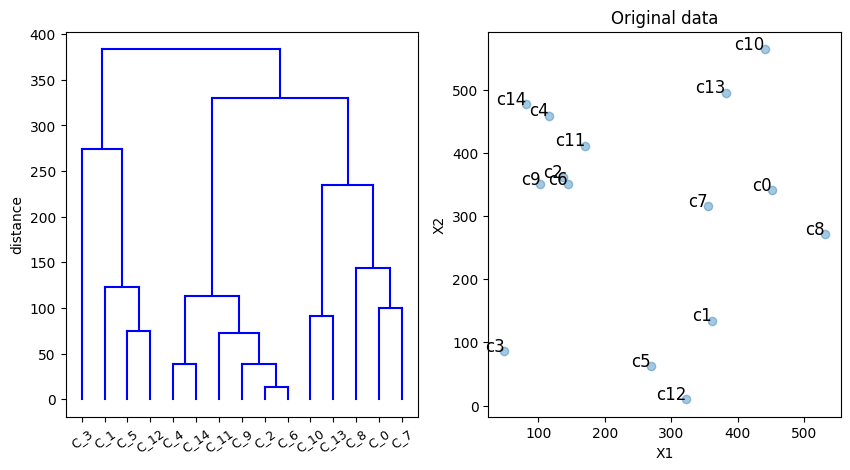

In [71]:
# function to plot the dendrogram
def plot_dendrogram(clusterwithcoordinates,figsize = (8,8)):

    # xlines = []
    # ylines = []
    plt.figure(figsize= figsize)
    plt.subplot(1,2,1)
    plt.plot([clusterwithcoordinates.rightcluster.xvalue, clusterwithcoordinates.leftcluster.xvalue ],[clusterwithcoordinates.plotline_yaxis_start_line, clusterwithcoordinates.plotline_yaxis_start_line ] ,color = 'blue')

    #print(xlines)
    def add_line(parent):
        #print(xlines)
        child_right = parent.rightcluster
        child_left = parent.leftcluster
        for clu in [child_right, child_left]:
            #print(xlines)
            plt.plot([clu.xvalue, clu.xvalue ],[clu.plotline_yaxis_start_line, clu.plotline_yaxis_end_line ] ,color = 'blue')
            if isinstance(clu, MixCluster):
                plt.plot([clu.rightcluster.xvalue, clu.leftcluster.xvalue ],[clu.plotline_yaxis_start_line, clu.plotline_yaxis_start_line ] ,color = 'blue')

            #plt.plot([clu.plotline_yaxis_start_line, clu.plotline_yaxis_start_line])

            #xlines.extend([clu.xvalue, clu.xvalue ])
            #print( [clu.xvalue, clu.plotline_yaxis_start_line ])
            #print(xlines)
            #ylines.extend([clu.plotline_yaxis_start_line, clu.plotline_yaxis_end_line ])
            #print( [clu.xvalue, clu.plotline_yaxis_end_line])
            if isinstance(clu, MixCluster):
                add_line(clu)

        
    add_line(clusterwithcoordinates)
    labels = [i.replace('Basecluster_', 'C_') for i in clusterwithcoordinates.cluster_name.split('-')]
    plt.xticks(ticks= range(len(labels)), labels= labels , rotation =35, ha = 'center')
    plt.tick_params(axis='x', labelsize= 9)
    plt.ylabel('distance')


    #plot the original data:
    plt.subplot(1,2,2)

    plt.scatter(data[:,0], data[:,1], alpha= 0.4)
    names = ["c" + str(i) for i in range(data.shape[0])]
    for i in range(data.shape[0]):
        plt.text(data[i,0], data[i,1], names[i], fontsize=12, ha='right', alpha = 1,)

    
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Original data')
    plt.show()

# plot the dendrogram
plot_dendrogram(master_cluster, figsize = (10,5))



## Repeat the clustering using ward distance

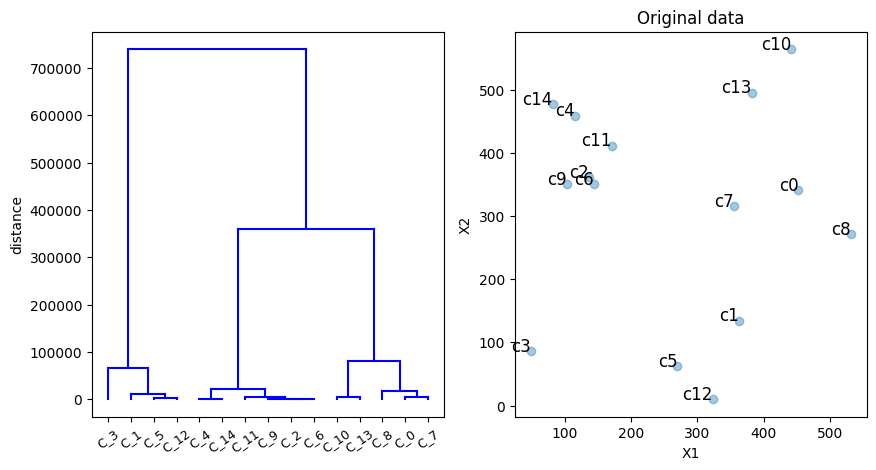

In [72]:
# cluster the data
master_cluster =  clustering(data=data , 
                             metric='ward', 
                             linkage= 'average')

# add x coordinates for each cluster
clustered_data = complete_xcoordinates(clustered_data = master_cluster)

# display the result
plot_dendrogram(master_cluster, figsize = (10,5))